In [ ]:
#!pip install matplotlib seaborn


In [15]:
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Dict

# Configuration visuelle
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Remplacez par l'URL publique si vous n'êtes pas sur localhost
API_URL = "http://localhost:5000/api/chat" 

print("✅ Bibliothèques prêtes.")

✅ Bibliothèques prêtes.


In [16]:
print("=" * 60)
print("SECTION 1: EXEMPLES DE REQUÊTES")
print("=" * 60)

# Dataset de questions de test avec réponses attendues
test_queries = [
    {
        "question": "Où se trouve le campus principal ?",
        "expected_contains": ["Paris", "La Défense"],
        "category": "Localisation"
    },
    {
        "question": "Qui est le directeur de l'esilv ?",
        "expected_contains": [ "Pascal", "Pinot"],
        "category": "Administration"
    },
    {
        "question": "Quelle est la durée du cursus ingénieur ?",
        "expected_contains": ["5 ans" ],
        "category": "Cursus"
    },
    {
        "question": "Existe-t-il un double diplôme ingénieur-manager ?",
        "expected_contains": ["double diplôme", "manager", "ingénieur", "oui", "EMLV"],
        "category": "Programmes"
    },
    {
        "question": "Y a-t-il un programme en Data Science ?",
        "expected_contains": ["data", "science", "oui"],
        "category": "Programmes"
    },
    {
        "question": "Quels sont les programmes disponibles ?",
        "expected_contains": ["programme", "bachelor", "majeur", "mastère", "ingénieur","prepa", "intégrée"],
        "category": "Programmes"
    },
    {
        "question": "Y a-t-il des bourses disponibles ?",
        "expected_contains": ["bourse", "aide", "financement","CROUS","oui"],
        "category": "Admission"
    },
    {
        "question": "Acceptez-vous les étudiants internationaux ?",
        "expected_contains": ["internationnaux", "échange","double","diplome", "admission","oui","erasmus"],
        "category": "Admission"
    },
    {
        "question": "Quelles sont les associations étudiantes ?",
        "expected_contains": ["association", "club", "étudiant","technique","culturel","sportif"],
        "category": "Vie Étudiante"
    },
    {
        "question": "Quelles activités sportives sont proposées ?",
        "expected_contains": ["sport", "activité", "boxe", "yoga","tennis"],
        "category": "Vie Étudiante"
    }
]

print(f"\n📝 Nombre de questions de test: {len(test_queries)}")
for i, query in enumerate(test_queries, 1):
    print(f"\n{i}. [{query['category']}] {query['question']}")



SECTION 1: EXEMPLES DE REQUÊTES

📝 Nombre de questions de test: 10

1. [Localisation] Où se trouve le campus principal ?

2. [Administration] Qui est le directeur de l'esilv ?

3. [Cursus] Quelle est la durée du cursus ingénieur ?

4. [Programmes] Existe-t-il un double diplôme ingénieur-manager ?

5. [Programmes] Y a-t-il un programme en Data Science ?

6. [Programmes] Quels sont les programmes disponibles ?

7. [Admission] Y a-t-il des bourses disponibles ?

8. [Admission] Acceptez-vous les étudiants internationaux ?

9. [Vie Étudiante] Quelles sont les associations étudiantes ?

10. [Vie Étudiante] Quelles activités sportives sont proposées ?


In [17]:

print("\n" + "=" * 60)
print("SECTION 2: MÉTRIQUES DE PRÉCISION")
print("=" * 60)

def query_chatbot(question: str) -> Dict:
    """Envoie une question au chatbot et récupère la réponse avec temps de latence"""
    start_time = time.time()
    
    try:
        response = requests.post(
            API_URL,
            json={"message": question},
            headers={"Content-Type": "application/json"},
            timeout=3000
            
        )
        
        latency = time.time() - start_time
        
        if response.status_code == 200:
            data = response.json()
            print(f"DEBUG - JSON reçu: {data}")
            return {
                "success": True,
                "response": data.get("message", ""),
                "latency": latency,
                "status_code": response.status_code
            }
        else:
            return {
                "success": False,
                "response": "",
                "latency": latency,
                "status_code": response.status_code,
                "error": response.text
            }
    except Exception as e:
        latency = time.time() - start_time
        return {
            "success": False,
            "response": "",
            "latency": latency,
            "error": str(e)
        }



def evaluate_response(response: str, expected_keywords: List[str]) -> float:
    """Évalue si la réponse contient les mots-clés attendus (recherche flexible)"""
    import re
    
    if not expected_keywords or not response:
        return 0.0
    
    response_lower = response.lower()
    # Normalisation : enlever accents et caractères spéciaux
    response_normalized = re.sub(r'[^\w\s]', ' ', response_lower)
    
    matches = 0
    for keyword in expected_keywords:
        keyword_lower = keyword.lower()
        keyword_normalized = re.sub(r'[^\w\s]', ' ', keyword_lower)
        
        # Cherche le mot-clé ou ses composants
        if keyword_normalized in response_normalized:
            matches += 1
        else:
            # Cherche les mots individuels du mot-clé
            words = keyword_normalized.split()
            if any(word in response_normalized for word in words if len(word) > 2):
                matches += 0.5  # Demi-point si au moins un mot est présent
    
    return min(matches / len(expected_keywords), 1.0)



SECTION 2: MÉTRIQUES DE PRÉCISION


In [18]:
results = []

print("\n🔄 Exécution des tests en cours...\n")

for i, test in enumerate(test_queries, 1):
    print(f"Test {i}/{len(test_queries)}: {test['question'][:50]}...")
    
    result = query_chatbot(test['question'])
    accuracy = evaluate_response(result['response'], test['expected_contains'])
    
    # Debug : afficher la réponse et les mots-clés trouvés
    print(f"  📄 Réponse: {result['response'][:100]}...")
    found_keywords = [kw for kw in test['expected_contains'] if kw.lower() in result['response'].lower()]
    print(f"  🔍 Mots-clés trouvés: {found_keywords if found_keywords else 'Aucun'}")
    
    results.append({
        "question": test['question'],
        "category": test['category'],
        "response": result['response'][:200],  # Tronqué pour lisibilité
        "latency": result['latency'],
        "accuracy": accuracy,
        "success": result['success']
    })
    
    print(f"  ✓ Latence: {result['latency']:.2f}s | Précision: {accuracy:.1%}\n")

# Création du DataFrame
df_results = pd.DataFrame(results)


🔄 Exécution des tests en cours...

Test 1/10: Où se trouve le campus principal ?...
DEBUG - JSON reçu: {'is_form': False, 'message': "Le campus principal de l'ESILV est situé à Paris-La Défense.", 'session_id': '25676f16-4e40-473d-a066-0d6acde99fb1', 'suggestions': ['Où se trouve le campus principal ?', 'Je souhaite être contacté', 'Quelles sont les associations étudiantes ?', 'Quelle est la durée du cursus ingénieur ?'], 'timestamp': '2025-12-19T11:20:10.280568'}
  📄 Réponse: Le campus principal de l'ESILV est situé à Paris-La Défense....
  🔍 Mots-clés trouvés: ['Paris', 'La Défense']
  ✓ Latence: 152.51s | Précision: 100.0%

Test 2/10: Qui est le directeur de l'esilv ?...
DEBUG - JSON reçu: {'is_form': False, 'message': "Le directeur de l'ESILV est Pascal Pinot .", 'session_id': '6e2561df-5a5a-440b-9336-7b95a78eb593', 'suggestions': ['Où se trouve le campus principal ?', 'Je souhaite être contacté', 'Quelles sont les associations étudiantes ?', 'Quelle est la durée du cursus ingénie

In [19]:

print("\n" + "=" * 60)
print("SECTION 3: RÉSULTATS GLOBAUX")
print("=" * 60)

# Statistiques générales
print(f"\n📊 STATISTIQUES GLOBALES:")
print(f"  • Taux de succès: {df_results['success'].mean():.1%}")
print(f"  • Précision moyenne: {df_results['accuracy'].mean():.1%}")
print(f"  • Latence moyenne: {df_results['latency'].mean():.2f}s")
print(f"  • Latence médiane: {df_results['latency'].median():.2f}s")
print(f"  • Latence min: {df_results['latency'].min():.2f}s")
print(f"  • Latence max: {df_results['latency'].max():.2f}s")

# Statistiques par catégorie
print(f"\n📈 PRÉCISION PAR CATÉGORIE:")
category_stats = df_results.groupby('category').agg({
    'accuracy': 'mean',
    'latency': 'mean'
}).round(2)
print(category_stats)



SECTION 3: RÉSULTATS GLOBAUX

📊 STATISTIQUES GLOBALES:
  • Taux de succès: 100.0%
  • Précision moyenne: 76.1%
  • Latence moyenne: 150.07s
  • Latence médiane: 148.40s
  • Latence min: 107.80s
  • Latence max: 188.62s

📈 PRÉCISION PAR CATÉGORIE:
                accuracy  latency
category                         
Administration      1.00   168.74
Admission           0.61   158.14
Cursus              1.00   177.15
Localisation        1.00   152.51
Programmes          0.70   128.51
Vie Étudiante       0.65   150.26



SECTION 4: VISUALISATIONS

✅ Graphique sauvegardé: evaluation_results.png


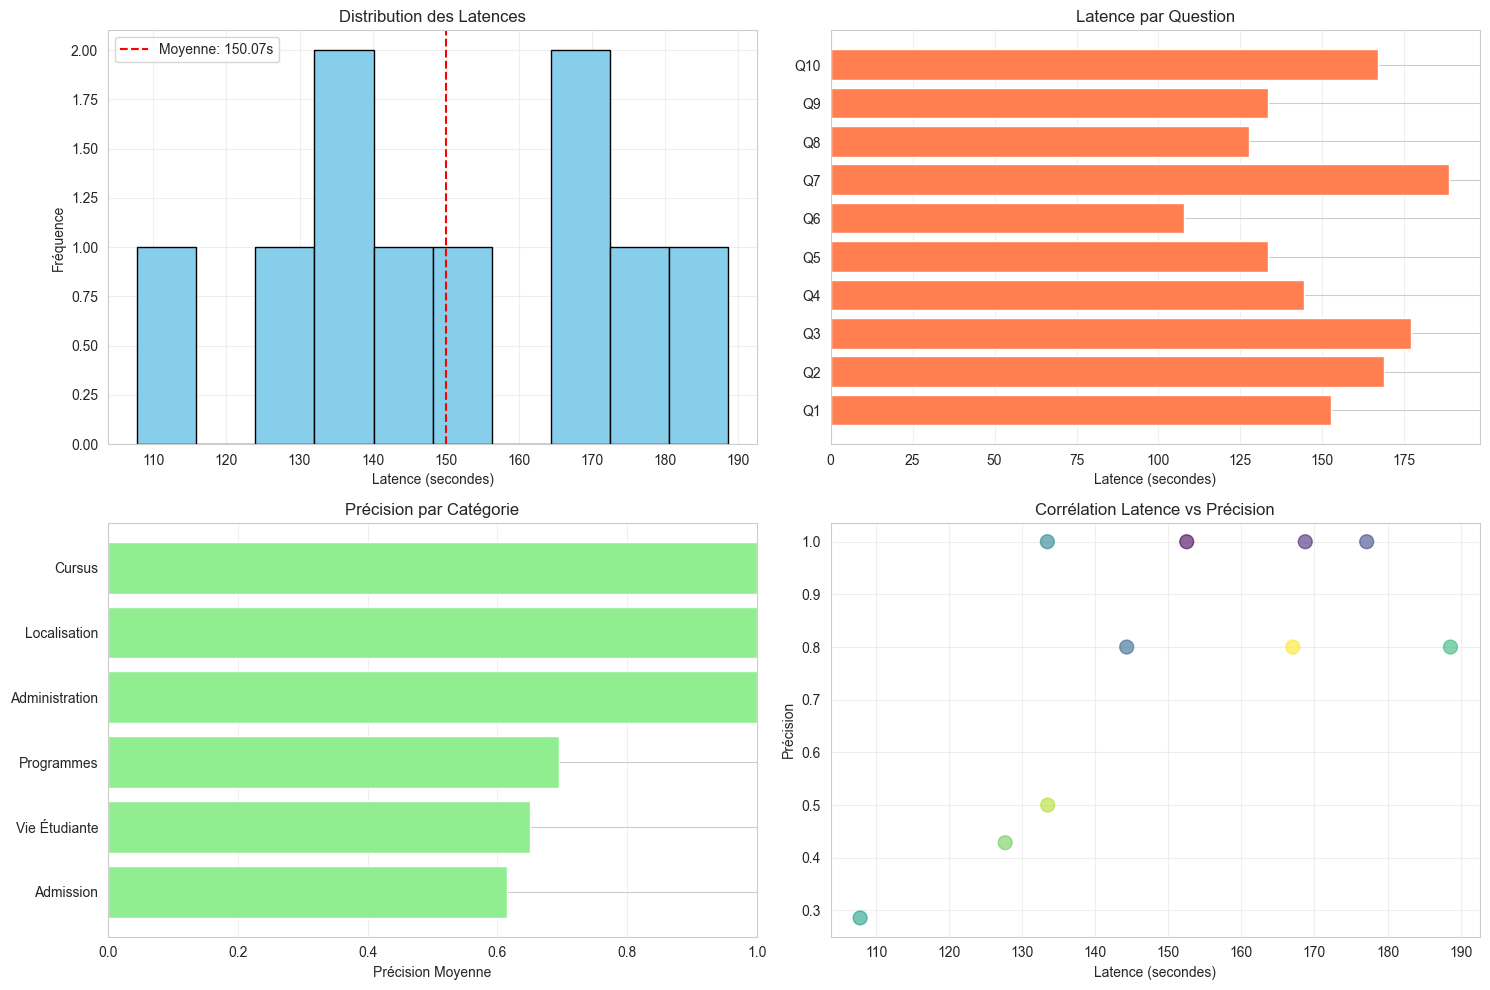

In [20]:

print("\n" + "=" * 60)
print("SECTION 4: VISUALISATIONS")
print("=" * 60)

# Figure 1: Distribution des latences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Graphique 1: Histogramme des latences
axes[0, 0].hist(df_results['latency'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].axvline(df_results['latency'].mean(), color='red', linestyle='--', label=f'Moyenne: {df_results["latency"].mean():.2f}s')
axes[0, 0].set_xlabel('Latence (secondes)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution des Latences')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Graphique 2: Latence par question
axes[0, 1].barh(range(len(df_results)), df_results['latency'], color='coral')
axes[0, 1].set_yticks(range(len(df_results)))
axes[0, 1].set_yticklabels([f"Q{i+1}" for i in range(len(df_results))])
axes[0, 1].set_xlabel('Latence (secondes)')
axes[0, 1].set_title('Latence par Question')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Graphique 3: Précision par catégorie
category_accuracy = df_results.groupby('category')['accuracy'].mean().sort_values()
axes[1, 0].barh(category_accuracy.index, category_accuracy.values, color='lightgreen')
axes[1, 0].set_xlabel('Précision Moyenne')
axes[1, 0].set_title('Précision par Catégorie')
axes[1, 0].set_xlim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Graphique 4: Latence vs Précision
scatter = axes[1, 1].scatter(df_results['latency'], df_results['accuracy'], 
                            c=df_results.index, cmap='viridis', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Latence (secondes)')
axes[1, 1].set_ylabel('Précision')
axes[1, 1].set_title('Corrélation Latence vs Précision')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Graphique sauvegardé: evaluation_results.png")
plt.show()


In [21]:

print("\n" + "=" * 60)
print("SECTION 5: EXPORT DES RÉSULTATS")
print("=" * 60)

# Sauvegarde CSV
df_results.to_csv('evaluation_results.csv', index=False)
print("✅ Résultats exportés: evaluation_results.csv")

# Sauvegarde JSON détaillée
detailed_results = {
    "metadata": {
        "date": time.strftime("%Y-%m-%d %H:%M:%S"),
        "total_queries": len(test_queries),
        "model": "gemma2:2b"
    },
    "summary": {
        "success_rate": float(df_results['success'].mean()),
        "avg_accuracy": float(df_results['accuracy'].mean()),
        "avg_latency": float(df_results['latency'].mean()),
        "median_latency": float(df_results['latency'].median())
    },
    "results": results
}

with open('evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(detailed_results, f, indent=2, ensure_ascii=False)
print("✅ Résultats détaillés: evaluation_results.json")



SECTION 5: EXPORT DES RÉSULTATS
✅ Résultats exportés: evaluation_results.csv
✅ Résultats détaillés: evaluation_results.json


In [23]:

print("\n" + "=" * 60)
print("SECTION 6: RECOMMANDATIONS")
print("=" * 60)

recommendations = []

if df_results['latency'].mean() > 5:
    recommendations.append("⚠️  Latence élevée détectée. Envisager l'optimisation du modèle ou du vectorstore, envisager un modèle plus rapide.")
    
if df_results['accuracy'].mean() < 0.7:
    recommendations.append("⚠️  Précision faible. Vérifier la qualité des documents source et le chunking.")
    
if df_results['success'].mean() < 0.95:
    recommendations.append("⚠️  Taux d'échec élevé. Vérifier la stabilité de l'API et d'Ollama.")

if recommendations:
    print("\n📌 POINTS D'AMÉLIORATION:")
    for rec in recommendations:
        print(f"  {rec}")
else:
    print("\n✅ Aucune amélioration critique nécessaire. Performances satisfaisantes!")

print("\n" + "=" * 60)
print("ÉVALUATION TERMINÉE ✅")
print("=" * 60)


SECTION 6: RECOMMANDATIONS

📌 POINTS D'AMÉLIORATION:
  ⚠️  Latence élevée détectée. Envisager l'optimisation du modèle ou du vectorstore, envisager un modèle plus rapide.

ÉVALUATION TERMINÉE ✅
